## **Step 1: Mount Google Drive and Unzip Dataset**

Start by mounting Google Drive to access dataset. The BBC dataset is provided as a zip file (`bbc_full_text.zip`). We'll extract its contents into a working directory so we can process the raw article text files from the five main categories (business, entertainment, politics, sports, tech).


Mount Google Drive

In [ ]:
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip the BBC dataset

In [ ]:
import zipfile
import os

# Your specific paths
zip_path = "/content/drive/MyDrive/NLP_Project/bbc-fulltext.zip"
extract_dir = "/content/drive/MyDrive/NLP_Project/"

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Successfully unzipped dataset into:", extract_dir)



Successfully unzipped dataset into: /content/drive/MyDrive/NLP_Project/


List extracted folders

In [ ]:
extract_dir = "/content/drive/MyDrive/NLP_Project/bbc/"

os.listdir(extract_dir)


['entertainment', 'business', 'sport', 'politics', 'README.TXT', 'tech']

 ## **Step 2: Load All .txt Articles into one DataFrame**



In [ ]:
import os
import pandas as pd

# Update path to include the correct 'bbc' subfolder
extract_dir = "/content/drive/MyDrive/NLP_Project/bbc/"

# List to hold data records
records = []

# Loop through all category folders and .txt files
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".txt"):
            category = os.path.basename(root)  # folder name = category
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read()
                records.append({
                    "filename": file,
                    "category": category,
                    "text": text
                })

# Convert to DataFrame
df = pd.DataFrame(records)

# Preview
print(f" Loaded {len(df)} articles.")
df.head()


 Loaded 2225 articles.


,filename,category,text
0,289.txt,entertainment,Musicians to tackle US red tape\n\nMusicians' ...
1,262.txt,entertainment,"U2's desire to be number one\n\nU2, who have w..."
2,276.txt,entertainment,Rocker Doherty in on-stage fight\n\nRock singe...
3,060.txt,entertainment,Snicket tops US box office chart\n\nThe film a...
4,074.txt,entertainment,Ocean's Twelve raids box office\n\nOcean's Twe...


Save the DataFrame as CSV to NLP_Project Folder

In [ ]:
# Define save location
save_path = "/content/drive/MyDrive/NLP_Project/bbc_full_combined.csv"

# Save the DataFrame
df.to_csv(save_path, index=False)

print(" Combined file saved to:", save_path)


 Combined file saved to: /content/drive/MyDrive/NLP_Project/bbc_full_combined.csv


Count Number of Rows in CSV

In [ ]:
import pandas as pd

# Load the CSV
csv_path = "/content/drive/MyDrive/NLP_Project/bbc_full_combined.csv"
df = pd.read_csv(csv_path)

# Count the number of rows (articles)
print(" Number of articles in CSV:", len(df))

# Preview first 3 rows
df.head(3)

# Show column names
df.columns


 Number of articles in CSV: 2225


Index(['filename', 'category', 'text'], dtype='object')

## **Step 3: Data Cleaning**

Data Cleaning Summary

This cell performs the following actions:
- Checks for missing values and drops rows that have any.
- Identifies duplicate articles and removes only the **first occurrence** of each (keeping the second).
- Overwrites the original combined dataset (`bbc_full_combined.csv`) with the cleaned data.

Cleaning stats:
- Original articles: 2225
- Missing rows dropped: 0
- Duplicate rows removed: 98
- Final total: 2127


In [ ]:
import pandas as pd

#  1. Load the combined data
csv_path = "/content/drive/MyDrive/NLP_Project/bbc_full_combined.csv"
df = pd.read_csv(csv_path)
print(" Loaded original dataset with:", len(df), "articles")

#  2. Check for missing values
missing_counts = df.isnull().sum()
total_missing = missing_counts.sum()
print("\n Missing value counts per column:")
print(missing_counts)

if total_missing == 0:
    print(" No missing values found.")
else:
    print(f" Total missing values: {total_missing}")
    print(" Dropping rows with missing values...")

# Drop rows with missing values
df_cleaned = df.dropna()
print(" After dropping missing rows:", len(df_cleaned))

#  3. De-duplicate by category + text (not filename)
df_final = df_cleaned.drop_duplicates(subset=['category', 'text'], keep='last')
num_removed = len(df_cleaned) - len(df_final)

print(f"\n Removed {num_removed} duplicates (same text within the same category).")
print(" Final dataset length:", len(df_final))

#  4. Overwrite the original CSV
df_final.to_csv(csv_path, index=False)
print(" Cleaned data saved (overwritten) to:", csv_path)



 Loaded original dataset with: 2225 articles

🔍 Missing value counts per column:
filename    0
category    0
text        0
dtype: int64
 No missing values found.
 After dropping missing rows: 2225

 Removed 98 duplicates (same text within the same category).
 Final dataset length: 2127
 Cleaned data saved (overwritten) to: /content/drive/MyDrive/NLP_Project/bbc_full_combined.csv


#**Step 4: GPT-3.5 Subcategorization**

Install & import depencies

In [ ]:
#!pip uninstall -y openai
!pip install --upgrade openai --quiet

In [ ]:
import openai
import pandas as pd
import os
import time

# Setup OpenAI v1.x client
client = openai.OpenAI(api_key="")  # Replace with your real API key


 Load Cleaned Data

In [ ]:
# Load the cleaned CSV
df = pd.read_csv("/content/drive/MyDrive/NLP_Project/bbc_full_combined.csv")
print(" Loaded dataset with:", len(df), "articles")


 Loaded dataset with: 2127 articles


Define Subcategory dictionary

In [ ]:
# Imports
import pandas as pd
import openai
import os
import time
import re
from openai import OpenAI

# Set up OpenAI client (replace with your actual key)
client = OpenAI(api_key="")

# Subcategory dictionary per main category
subcategory_dict = {
    "sport": [
        "Football", "Rugby", "Tennis", "Cricket", "Athletics",
        "Golf", "Formula 1", "Boxing", "Cycling"
    ],
    "business": [
        "Markets & Finance", "Banking & Insurance", "Energy & Commodities",
        "Legal & Regulatory", "Employment & Labor", "Industry & Manufacturing",
        "Transport & Travel", "Healthcare & Pharma", "Technology & Telecom",
        "Retail, Consumer & Entertainment", "Government & Policy"
    ],
    "entertainment": [
        "TV & Streaming", "Music", "Film & Cinema", "Celebrities", "Awards & Festivals",
        "Theatre & Performing Arts", "Culture & Lifestyle", "Gaming", "Books & Literature",
        "Internet Culture & Memes", "Comedy & Sports", "Visual Arts & Exhibitions", "Radio & Podcasts"
    ],
    "politics": [
        "Elections", "Foreign Affairs", "Legislation & Parliament", "Political Scandals",
        "Government Policy", "Protest & Activism", "Public Services",
        "Political Parties", "Leadership Changes"
    ],
    "tech": [
        "AI & Machine Learning", "Cybersecurity", "Social Media & Platforms",
        "Gadgets & Devices", "Internet & Connectivity", "Software & Apps",
        "Tech Business & Mergers", "Data Privacy & Regulation", "Science & Innovation"
    ]
}

# Function to clean GPT response
def clean(text):
    return re.sub(r'[^a-zA-Z0-9 &-/]', '', str(text).strip())

# Function to build prompt for GPT
def build_prompt(article_text, category):
    subcats = ', '.join(subcategory_dict.get(category, ["Other"]))
    return (
        f"You are a BBC {category} news analyst. Read the article below and choose the best subcategory from this list:\n\n"
        f"{subcats}\n\n"
        f"Only return the subcategory in one line.\n\n"
        f"Article:\n\"\"\"{article_text}\"\"\""
    )

# Load full combined CSV
csv_path = "/content/drive/MyDrive/NLP_Project/bbc_full_combined.csv"
df = pd.read_csv(csv_path)

#  Add subcategory column if it doesn't exist
if 'subcategory' not in df.columns:
    df['subcategory'] = ""
    df.to_csv(csv_path, index=False)
    print(" 'subcategory' column added to full dataset.")
else:
    print(" 'subcategory' column already exists.")

# Output folder for saving results
output_base = "/content/drive/MyDrive/NLP_Project/Subcategories"
os.makedirs(output_base, exist_ok=True)

# Loop through all categories
for category in subcategory_dict.keys():
    print(f"\nProcessing category: {category}")

    df_cat = df[df['category'] == category].copy().reset_index(drop=True)

    # Confirm 'subcategory' column still exists in the filtered subset
    if 'subcategory' not in df_cat.columns:
        raise ValueError(f"'subcategory' column missing in {category} dataset. Please ensure it exists before running.")

    # Prepare save path per category
    save_path = os.path.join(output_base, category, f"bbc_{category}_subcategories.csv")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for i, row in df_cat.iterrows():
        if isinstance(row['subcategory'], str) and row['subcategory'].strip() != "":
            continue  # Already processed

        prompt = build_prompt(row['text'], category)

        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": f"You classify BBC {category} articles into subcategories."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                max_tokens=50
            )
            subcat = clean(response.choices[0].message.content)
            df_cat.at[i, "subcategory"] = subcat
            print(f"✓ Article {i+1}/{len(df_cat)} → {subcat}")

        except Exception as e:
            print(f"Error at article {i+1} in {category}: {e}")
            df_cat.at[i, "subcategory"] = "Error"
            continue

        # Save every 10 articles
        if i % 10 == 0:
            df_cat.to_csv(save_path, index=False)
            print(f"Autosaved after {i+1} articles in {category}")

        time.sleep(1.5)  # Short pause to respect rate limits

    # Final save per category
    df_cat.to_csv(save_path, index=False)
    print(f"Finished {category}. Saved to: {save_path}")


 'subcategory' column already exists.

Processing category: sport


/tmp/ipython-input-24-346632081.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Rugby' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cat.at[i, "subcategory"] = subcat


✓ Article 1/505 → Rugby
Autosaved after 1 articles in sport
✓ Article 2/505 → Tennis
✓ Article 3/505 → Football
✓ Article 4/505 → Football
✓ Article 5/505 → Tennis
✓ Article 6/505 → Athletics
✓ Article 7/505 → Athletics
✓ Article 8/505 → Athletics
✓ Article 9/505 → Football
✓ Article 10/505 → Football
✓ Article 11/505 → Football
Autosaved after 11 articles in sport
✓ Article 12/505 → Tennis
✓ Article 13/505 → Rugby
✓ Article 14/505 → Rugby
✓ Article 15/505 → Tennis
✓ Article 16/505 → Tennis
✓ Article 17/505 → Tennis
✓ Article 18/505 → Rugby
✓ Article 19/505 → Tennis
✓ Article 20/505 → Tennis
✓ Article 21/505 → Rugby
Autosaved after 21 articles in sport
✓ Article 22/505 → Football
✓ Article 23/505 → Football
✓ Article 24/505 → Football
✓ Article 25/505 → Athletics
✓ Article 26/505 → Athletics
✓ Article 27/505 → Athletics
✓ Article 28/505 → Football
✓ Article 29/505 → Tennis
✓ Article 30/505 → Tennis
✓ Article 31/505 → Football
Autosaved after 31 articles in sport
✓ Article 32/505 → Rugb

/tmp/ipython-input-24-346632081.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Industry & Manufacturing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cat.at[i, "subcategory"] = subcat


✓ Article 1/503 → Industry & Manufacturing
Autosaved after 1 articles in business
✓ Article 2/503 → Government & Policy
✓ Article 3/503 → Markets & Finance
✓ Article 4/503 → Energy & Commodities
✓ Article 5/503 → Industry & Manufacturing
✓ Article 6/503 → Legal & Regulatory
✓ Article 7/503 → Government & Policy
✓ Article 8/503 → Markets & Finance
✓ Article 9/503 → Legal & Regulatory
✓ Article 10/503 → Legal & Regulatory
✓ Article 11/503 → Transport & Travel
Autosaved after 11 articles in business
✓ Article 12/503 → Industry & Manufacturing
✓ Article 13/503 → Markets & Finance
✓ Article 14/503 → Healthcare & Pharma
✓ Article 15/503 → Markets & Finance
✓ Article 16/503 → Legal & Regulatory
✓ Article 17/503 → Government & Policy
✓ Article 18/503 → Government & Policy
✓ Article 19/503 → Legal & Regulatory
✓ Article 20/503 → Government & Policy
✓ Article 21/503 → Retail
Autosaved after 21 articles in business
✓ Article 22/503 → Technology & Telecom
✓ Article 23/503 → Markets & Finance
✓ Art

/tmp/ipython-input-24-346632081.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Music' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cat.at[i, "subcategory"] = subcat


✓ Article 1/369 → Music
Autosaved after 1 articles in entertainment
✓ Article 2/369 → Music
✓ Article 3/369 → Music
✓ Article 4/369 → Film & Cinema
✓ Article 5/369 → Film & Cinema
✓ Article 6/369 → Celebrities
✓ Article 7/369 → Film & Cinema
✓ Article 8/369 → Music
✓ Article 9/369 → Celebrities
✓ Article 10/369 → Film & Cinema
✓ Article 11/369 → Film & Cinema
Autosaved after 11 articles in entertainment
✓ Article 12/369 → Awards & Festivals
✓ Article 13/369 → Film & Cinema
✓ Article 14/369 → Celebrities
✓ Article 15/369 → Film & Cinema
✓ Article 16/369 → Film & Cinema
✓ Article 17/369 → Theatre & Performing Arts
✓ Article 18/369 → Music
✓ Article 19/369 → Music
✓ Article 20/369 → Theatre & Performing Arts
✓ Article 21/369 → Music
Autosaved after 21 articles in entertainment
✓ Article 22/369 → Awards & Festivals
✓ Article 23/369 → Film & Cinema
✓ Article 24/369 → Film & Cinema
✓ Article 25/369 → Awards & Festivals
✓ Article 26/369 → Music
✓ Article 27/369 → Film & Cinema
✓ Article 28/36

/tmp/ipython-input-24-346632081.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Leadership Changes' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cat.at[i, "subcategory"] = subcat


✓ Article 1/403 → Leadership Changes
Autosaved after 1 articles in politics
✓ Article 2/403 → Leadership Changes
✓ Article 3/403 → Political Parties
✓ Article 4/403 → Foreign Affairs
✓ Article 5/403 → Political Scandals
✓ Article 6/403 → Legislation & Parliament
✓ Article 7/403 → Elections
✓ Article 8/403 → Political Scandals
✓ Article 9/403 → Government Policy
✓ Article 10/403 → Political Scandals
✓ Article 11/403 → Political Parties
Autosaved after 11 articles in politics
✓ Article 12/403 → Leadership Changes
✓ Article 13/403 → Government Policy
✓ Article 14/403 → Foreign Affairs
✓ Article 15/403 → Government Policy
✓ Article 16/403 → Legislation & Parliament
✓ Article 17/403 → Legislation & Parliament
✓ Article 18/403 → Political Scandals
✓ Article 19/403 → Public Services
✓ Article 20/403 → Government Policy
✓ Article 21/403 → Leadership Changes
Autosaved after 21 articles in politics
✓ Article 22/403 → Leadership Changes
✓ Article 23/403 → Political Parties
✓ Article 24/403 → Poli

/tmp/ipython-input-24-346632081.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Internet & Connectivity' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cat.at[i, "subcategory"] = subcat


✓ Article 1/347 → Internet & Connectivity
Autosaved after 1 articles in tech
✓ Article 2/347 → Tech Business & Mergers
✓ Article 3/347 → Cybersecurity
✓ Article 4/347 → Internet & Connectivity
✓ Article 5/347 → Tech Business & Mergers
✓ Article 6/347 → Tech Business & Mergers
✓ Article 7/347 → Science & Innovation
✓ Article 8/347 → Cybersecurity
✓ Article 9/347 → Internet & Connectivity
✓ Article 10/347 → Science & Innovation
✓ Article 11/347 → Data Privacy & Regulation
Autosaved after 11 articles in tech
✓ Article 12/347 → Cybersecurity
✓ Article 13/347 → Data Privacy & Regulation
✓ Article 14/347 → Science & Innovation
✓ Article 15/347 → Gadgets & Devices
✓ Article 16/347 → Internet & Connectivity
✓ Article 17/347 → Software & Apps
✓ Article 18/347 → Gadgets & Devices
✓ Article 19/347 → Social Media & Platforms
✓ Article 20/347 → Cybersecurity
✓ Article 21/347 → Cybersecurity
Autosaved after 21 articles in tech
✓ Article 22/347 → Gadgets & Devices
✓ Article 23/347 → Science & Innovat

#**Step 5: Confirm data integrity & subcategory accuracy**

In [ ]:
import os

base_path = "/content/drive/MyDrive/NLP_Project/Subcategories"

for category in os.listdir(base_path):
    cat_path = os.path.join(base_path, category)
    print(f"\nCategory: {category}")
    for file in os.listdir(cat_path):
        print(" -", file)



Category: sport
 - bbc_sport_subcategories.csv

Category: business
 - bbc_business_subcategories.csv

Category: entertainment
 - bbc_entertainment_subcategories.csv

Category: politics
 - bbc_politics_subcategories.csv

Category: tech
 - bbc_tech_subcategories.csv


In [ ]:
import pandas as pd
import os

# Define base path to subcategories folder
base_path = "/content/drive/MyDrive/NLP_Project/Subcategories"

# Define mapping of categories to filenames
category_files = {
    "sport": "bbc_sport_subcategories.csv",
    "business": "bbc_business_subcategories.csv",
    "entertainment": "bbc_entertainment_subcategories.csv",
    "politics": "bbc_politics_subcategories.csv",
    "tech": "bbc_tech_subcategories.csv"
}

# Initialize list to collect results
results = []

# Loop through each category and load data
for category, filename in category_files.items():
    file_path = os.path.join(base_path, category, filename)
    try:
        df = pd.read_csv(file_path)
        count = len(df)
        results.append({"Category": category.capitalize(), "Articles": count})
    except Exception as e:
        results.append({"Category": category.capitalize(), "Articles": f"Error: {e}"})

# Create dataframe of counts
summary_df = pd.DataFrame(results)

# Display result
print(" Subcategory Article Counts:\n")
print(summary_df)

# Show total if all values are numeric
if pd.api.types.is_numeric_dtype(summary_df["Articles"]):
    total = summary_df["Articles"].sum()
    print(f"\n🧾 Total articles across all categories: {total}")


 Subcategory Article Counts:

        Category  Articles
0          Sport       505
1       Business       503
2  Entertainment       369
3       Politics       403
4           Tech       347

🧾 Total articles across all categories: 2127


Subcategory distribution

In [ ]:
import os
import pandas as pd

# Automatically scan and build category paths
base_path = "/content/drive/MyDrive/NLP_Project/Subcategories"

# Get all CSVs inside each category folder
category_files = {}
for category_folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, category_folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                category_files[category_folder] = os.path.join(folder_path, file)

# Dictionary to store each category's unique subcategories
subcategory_lists = {}
for category, file_path in category_files.items():
    try:
        df = pd.read_csv(file_path)
        subcats = sorted(df['subcategory'].dropna().unique().tolist())
        subcategory_lists[category.capitalize()] = subcats
    except Exception as e:
        subcategory_lists[category.capitalize()] = [f"Error: {e}"]

# Pad shorter lists so we can display as DataFrame
max_length = max(len(v) for v in subcategory_lists.values())
for key in subcategory_lists:
    subcategory_lists[key] += [""] * (max_length - len(subcategory_lists[key]))

# Display the table
subcat_df = pd.DataFrame(subcategory_lists)
subcat_df  # This will display the full subcategory breakdown by category


,Sport,Business,Entertainment,Politics,Tech
0,Athletics,Banking & Insurance,Awards & Festivals,Elections,AI & Machine Learning
1,Boxing,Construction & Real Estate,Books & Literature,Foreign Affairs,Cybersecurity
2,Football,Employment & Labor,Celebrities,Government Policy,Data Privacy & Regulation
3,Rugby,Energy & Commodities,Comedy & Sports,Leadership Changes,Gadgets & Devices
4,Tennis,Government & Policy,Culture & Lifestyle,Legislation & Parliament,Internet & Connectivity
5,,Healthcare & Pharma,Film & Cinema,Political Parties,Science & Innovation
6,,Industry & Manufacturing,Music,Political Scandals,Social Media & Platforms
7,,Insurance & Risk Management,Radio & Podcasts,Protest & Activism,Software & Apps
8,,Legal & Regulatory,TV & Streaming,Public Services,Tech Business & Mergers
9,,Markets & Finance,Theatre & Performing Arts,,Wearable technology and smart fabrics are disc...


Python Script to Find the Misclassified Tech Subcategory

In [ ]:
import pandas as pd

# Path to your Tech CSV file
file_path = "/content/drive/MyDrive/NLP_Project/Subcategories/tech/bbc_tech_subcategories.csv"

# Load the CSV
df = pd.read_csv(file_path)

# Normalize the subcategory column by stripping spaces and collapsing whitespace
df['subcategory_clean'] = df['subcategory'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()

# Define the key phrase to search for (use lowercased, normalized form)
search_phrase = "wearable technology and smart fabrics are discussed in the article, indicating a focus on gadgets & devices"
search_phrase = search_phrase.strip().lower()

# Filter rows using .str.contains to match even partially if needed
matches = df[df['subcategory_clean'].str.lower().str.contains(search_phrase)]

# Optional: add a fake filename column (if needed for tracking)
matches['file'] = file_path.split("/")[-1]  # Adds file name to help trace back

# Display the subcategory, text, and file name
display_df = matches[['file', 'subcategory', 'text']].reset_index(drop=True)

# Display nicely if you're in Colab or Jupyter
import IPython.display as display
display.display(display_df)

# Also print how many were found
print(f"Found {len(display_df)} matching article(s) in tech.")


/tmp/ipython-input-31-3376719470.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches['file'] = file_path.split("/")[-1]  # Adds file name to help trace back


,file,subcategory,text
0,bbc_tech_subcategories.csv,Wearable technology and smart fabrics are disc...,"When technology gets personal\n\nIn 2020, whip..."


Found 1 matching article(s) in tech.


Replace the misclassified subcategory text with "Gadgets & Devices"

In [ ]:
import pandas as pd
from IPython.display import display  # <-- This is the missing import

# Load the tech subcategories CSV
file_path = "/content/drive/MyDrive/NLP_Project/Subcategories/tech/bbc_tech_subcategories.csv"
df = pd.read_csv(file_path)

# Identify rows that contain the undesired subcategory text
mask = df['subcategory'].str.contains("wearable technology and smart fabrics", case=False, na=False)

# Show how many rows matched
print(f"Found {mask.sum()} article(s) with the misclassified subcategory.\n")

# Display the matched rows
display(df.loc[mask, ['subcategory', 'text']])

# Replace with the correct label
df.loc[mask, 'subcategory'] = "Gadgets & Devices"

# Save updated CSV
df.to_csv(file_path, index=False)
print(" Replacement complete. File has been updated.")

# Confirm all current subcategories
unique_subcategories = sorted(df['subcategory'].dropna().unique().tolist())
print("\n Unique Tech Subcategories:")
for i, subcat in enumerate(unique_subcategories, start=1):
    print(f"{i}. {subcat}")



Found 1 article(s) with the misclassified subcategory.



,subcategory,text
92,Wearable technology and smart fabrics are disc...,"When technology gets personal\n\nIn 2020, whip..."


 Replacement complete. File has been updated.

 Unique Tech Subcategories:
1. AI & Machine Learning
2. Cybersecurity
3. Data Privacy & Regulation
4. Gadgets & Devices
5. Internet & Connectivity
6. Science & Innovation
7. Social Media & Platforms
8. Software & Apps
9. Tech Business & Mergers


In [ ]:
import os
import pandas as pd

# Base folder
base_folder = '/content/drive/MyDrive/NLP_Project/Subcategories'

# Categories
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Initialize list to hold each dataframe
dfs = []

# Loop through categories and read their CSVs
for category in categories:
    file_path = os.path.join(base_folder, category, f"bbc_{category}_subcategories.csv")

    if os.path.exists(file_path):
        print(f"Loading {file_path}")
        df = pd.read_csv(file_path)
        dfs.append(df)
    else:
        print(f"File not found for {category}: {file_path}")

# Concatenate all dataframes into one
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)

    # Preview
    print("Combined Data Preview")
    print(combined_df.head())

    # Save as new combined CSV
    combined_path = os.path.join(base_folder, 'bbc_combined_subcategories.csv')
    combined_df.to_csv(combined_path, index=False)
    print(f"Combined dataset saved to {combined_path}")
else:
    print("No dataframes loaded. Please check file paths.")


Loading /content/drive/MyDrive/NLP_Project/Subcategories/business/bbc_business_subcategories.csv
Loading /content/drive/MyDrive/NLP_Project/Subcategories/entertainment/bbc_entertainment_subcategories.csv
Loading /content/drive/MyDrive/NLP_Project/Subcategories/politics/bbc_politics_subcategories.csv
Loading /content/drive/MyDrive/NLP_Project/Subcategories/sport/bbc_sport_subcategories.csv
Loading /content/drive/MyDrive/NLP_Project/Subcategories/tech/bbc_tech_subcategories.csv
Combined Data Preview
  filename  category                                               text  \
0  289.txt  business  UK economy facing 'major risks'\n\nThe UK manu...   
1  504.txt  business  Aids and climate top Davos agenda\n\nClimate c...   
2  262.txt  business  Asian quake hits European shares\n\nShares in ...   
3  276.txt  business  India power shares jump on debut\n\nShares in ...   
4  510.txt  business  Lacroix label bought by US firm\n\nLuxury good...   

                subcategory  
0  Industry & Ma

#**Step 6: Named Entity Recognition (NER) + April Event Extraction**

In [ ]:
!pip install --upgrade openai


In [ ]:
# Imports
import pandas as pd
import openai
import time
import os

# Set up OpenAI client
client = openai.OpenAI(api_key="") #requires secret key

# File paths
csv_path = "/content/drive/MyDrive/NLP_Project/Subcategories/bbc_combined_subcategories.csv"
ner_output = "/content/drive/MyDrive/NLP_Project/NER_named_entities.csv"
april_output = "/content/drive/MyDrive/NLP_Project/April_events_summary.csv"

# Smart April event detector
def is_probably_april_event(text: str):
    text = text.lower()
    april_patterns = [
        "april", "easter", "spring", "04", "4th month", "fourth month",
        "2 april", "april 2", "2nd of april", "early april", "mid-april", "late april",
        "second week of april", "april weekend"
    ]
    return any(pattern in text for pattern in april_patterns)

# Load dataset
df = pd.read_csv(csv_path)

# Load existing outputs for resume capability
ner_df = pd.read_csv(ner_output) if os.path.exists(ner_output) else pd.DataFrame(columns=["filename", "category", "people", "job_title"])
april_df = pd.read_csv(april_output) if os.path.exists(april_output) else pd.DataFrame(columns=["filename", "category", "april_events"])

processed_files = set(ner_df['filename']).union(set(april_df['filename']))
batch_size = 50
counter = 0

# Start processing
for i, row in df.iterrows():
    filename = row['filename']
    if filename in processed_files:
        continue

    category = row['category']
    article_text = row['text']

    prompt = (
        "You are an expert information extractor. From the article below, extract:\n"
        "1. People mentioned and their job titles. Only include public figures like politicians, musicians, actors, etc.\n"
        "2. Summarize any events that happened in or are scheduled for April.\n\n"
        "Format strictly as:\n"
        "People:\n"
        "- Name: <person> | Role: <job title>\n\n"
        "April Events:\n"
        "- <event description>\n\n"
        f"Article:\n\"\"\"{article_text}\"\"\""
    )

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=700
        )

        result = response.choices[0].message.content

        if "People:" not in result or "April Events:" not in result:
            print(f" Skipping article {i+1}: missing expected sections")
            continue

        try:
            people_raw = result.split("People:")[1].split("April Events:")[0].strip()
            april_raw = result.split("April Events:")[1].strip()
        except Exception as e:
            print(f" Skipping article {i+1}: split error - {e}")
            continue

        # Process named entities
        for line in people_raw.splitlines():
            if "| Role:" in line and "- Name:" in line:
                try:
                    name_part, role_part = line.split("| Role:")
                    person = name_part.replace("- Name:", "").strip()
                    role = role_part.strip()
                    if person and role:
                        ner_df.loc[len(ner_df)] = [filename, category, person, role]
                except Exception as e:
                    print(f" Skipping malformed person-role line: {line} | Error: {e}")

        # Process April events (with enhanced pattern matching)
        if is_probably_april_event(april_raw):
            try:
                april_df.loc[len(april_df)] = [filename, category, april_raw]
            except Exception as e:
                print(f" Skipping April event due to column mismatch: {e}")

        print(f"✓ Processed article {i+1}/{len(df)}")

        counter += 1
        if counter % batch_size == 0:
            ner_df.to_csv(ner_output, index=False)
            april_df.to_csv(april_output, index=False)
            print(f" Autosaved after {counter} articles")

        time.sleep(1.5)

    except Exception as e:
        print(f" Error at article {i+1}: {e}")
        continue

# Final save
ner_df.to_csv(ner_output, index=False)
april_df.to_csv(april_output, index=False)

print(" Named entities saved to:", ner_output)
print(" April events saved to:", april_output)




✓ Processed article 1/2127
✓ Processed article 2/2127
✓ Processed article 3/2127
✓ Processed article 4/2127
✓ Processed article 5/2127
✓ Processed article 6/2127
✓ Processed article 7/2127
✓ Processed article 8/2127
✓ Processed article 9/2127
✓ Processed article 10/2127
✓ Processed article 11/2127
✓ Processed article 12/2127
✓ Processed article 13/2127
✓ Processed article 14/2127
✓ Processed article 15/2127
✓ Processed article 16/2127
✓ Processed article 17/2127
✓ Processed article 18/2127
✓ Processed article 19/2127
✓ Processed article 20/2127
✓ Processed article 21/2127
✓ Processed article 22/2127
✓ Processed article 23/2127
✓ Processed article 24/2127
✓ Processed article 25/2127
✓ Processed article 26/2127
✓ Processed article 27/2127
✓ Processed article 28/2127
✓ Processed article 29/2127
✓ Processed article 30/2127
✓ Processed article 31/2127
✓ Processed article 32/2127
✓ Processed article 33/2127
✓ Processed article 34/2127
✓ Processed article 35/2127
✓ Processed article 36/2127
✓

In [ ]:
import pandas as pd

# Define the file path
april_path = "/content/drive/MyDrive/NLP_Project/April_events_summary.csv"

# Load the data
df = pd.read_csv(april_path)

# Define the exact string to drop
drop_text = "- No specific events mentioned for April in the article."

# Drop rows where any column contains the exact drop text
df_cleaned = df[~df.apply(lambda row: row.astype(str).str.contains(drop_text)).any(axis=1)]

# Save the cleaned DataFrame back to the same file
df_cleaned.to_csv(april_path, index=False)

print(" All rows with unwanted April events have been dropped and file updated.")



 All rows with unwanted April events have been dropped and file updated.


#**Step 7: Model Evaluation**


This section evaluates the performance of the GPT-3.5 model's subcategorization on the sports dataset. We will load the reference data and the GPT-predicted subcategories, merge them based on article text, and then calculate classification metrics (Accuracy, Precision, Recall, F1-score) and display a Confusion Matrix to understand how well the model classified the articles into the defined sports subcategories. We will also handle duplicate texts in the reference data before evaluation.




In [ ]:
import pandas as pd
import os

# Read the filenames from bbcsport.docs
docs_path = '/content/drive/MyDrive/NLP_Project/bbcsport/bbcsport.docs'
with open(docs_path, 'r') as f:
    docs = [line.strip() for line in f if line.strip()]

# Read the class mappings from bbcsport.classes
classes_path = '/content/drive/MyDrive/NLP_Project/bbcsport/bbcsport.classes' # Corrected file path
with open(classes_path, 'r') as f:
    lines = [line.strip() for line in f if line.strip()]

# Extract class names from the %Clusters line
cluster_line = next(line for line in lines if line.startswith('%Clusters'))
class_names = cluster_line.split()[2].split(',')

# Find where %Objects starts and get mappings
obj_start = lines.index('%Objects') + 1
mappings = lines[obj_start:]

# Build mapping: doc index -> class index
doc_class = [int(line.split()[1]) for line in mappings]

# Build DataFrame: filename, category
df = pd.DataFrame({
    'filename': docs,
    'category': [class_names[i] for i in doc_class]
})

# Create the output directory if it doesn't exist
output_dir = '/content/drive/MyDrive/NLP_Project/bbcsport'
os.makedirs(output_dir, exist_ok=True)

# Save as CSV in the specified directory
output_path = os.path.join(output_dir, 'bbcsport_reference.csv')
df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

Saved: /content/drive/MyDrive/NLP_Project/bbcsport/bbcsport_reference.csv


In [ ]:
# prompt: read to 10 output_path, use df()

import pandas as pd
output_path = "/content/drive/MyDrive/NLP_Project/bbcsport/bbcsport_reference.csv"
df = pd.read_csv(output_path)
print(df.head(10))

        filename   category
0  athletics.001  athletics
1  athletics.002  athletics
2  athletics.003  athletics
3  athletics.004  athletics
4  athletics.005  athletics
5  athletics.006  athletics
6  athletics.007  athletics
7  athletics.008  athletics
8  athletics.009  athletics
9  athletics.010  athletics


 Load Article Text into Reference CSV

In [ ]:
import os

# Load your reference CSV
ref_path = '/content/drive/MyDrive/NLP_Project/bbcsport/bbcsport_reference.csv'
ref_df = pd.read_csv(ref_path)

# BBC sports folders (adjust path if needed)
base_folder = '/content/drive/MyDrive/NLP_Project/bbcsport/bbcsport_txt'
folders = ['athletics', 'cricket', 'football', 'rugby', 'tennis']

# Function to get text for a filename
def get_article_text(filename):
    category, num = filename.split('.')
    file_path = os.path.join(base_folder, category, f"{num}.txt")
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            return f.read().strip()
    return ""

# Add text column
ref_df['text'] = ref_df['filename'].apply(get_article_text)

# Save as a new CSV file
new_path = '/content/drive/MyDrive/NLP_Project/bbcsport/bbcsport_reference_with_text.csv'
ref_df.to_csv(new_path, index=False)
print(f"Text column added and saved to {new_path}")

Text column added and saved to /content/drive/MyDrive/NLP_Project/bbcsport/bbcsport_reference_with_text.csv


Clean & Merge Subcategory Predictions for Evaluation

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
subcat_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/Subcategories/sport/bbc_sport_subcategories.csv')  # <--- subcat_df is created here
reference_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/bbcsport/bbcsport_reference_with_text.csv') # <--- reference_df is created here

# Clean 'text' columns to ensure exact matching by removing leading/trailing spaces
subcat_df['text'] = subcat_df['text'].str.strip()
reference_df['text'] = reference_df['text'].str.strip()

# Find and display duplicate texts in reference_df
print("Duplicate texts found in reference_df (showing all occurrences BEFORE dropping):")
duplicate_texts_mask_before_drop = reference_df['text'].duplicated(keep=False)
duplicate_rows_before_drop = reference_df[duplicate_texts_mask_before_drop].sort_values(by='text')
display(duplicate_rows_before_drop)
print(f"\nTotal number of rows with duplicate text BEFORE dropping: {len(duplicate_rows_before_drop)}")
print(f"Number of unique duplicate texts BEFORE dropping: {duplicate_rows_before_drop['text'].nunique()}")


# Drop duplicate texts from reference_df, keeping the first occurrence
reference_df_cleaned = reference_df.drop_duplicates(subset=['text'], keep='first').copy()
print(f"\nReference_df after dropping duplicates: {len(reference_df_cleaned)} rows")

# Standardise labels to lowercase and strip spaces for consistency
subcat_df['subcategory'] = subcat_df['subcategory'].str.lower().str.strip()
reference_df_cleaned['category'] = reference_df_cleaned['category'].str.lower().str.strip()

# Merge datasets on the 'text' column using the cleaned reference_df
merged_df = pd.merge(reference_df_cleaned, subcat_df, on='text', how='inner', suffixes=('_ref', '_pred'))

print(f"\nMerged_df after merging with cleaned reference_df: {len(merged_df)} rows")


# True and predicted labels
y_true = merged_df['category_ref']
y_pred = merged_df['subcategory']

# Create a column to check correctness
merged_df['is_correct'] = merged_df['category_ref'] == merged_df['subcategory']

Duplicate texts found in reference_df (showing all occurrences BEFORE dropping):


,filename,category,text
624,rugby.135,rugby,Bortolami predicts dour contest\n\nItaly skipp...
541,rugby.052,rugby,Bortolami predicts dour contest\n\nItaly skipp...
11,athletics.012,athletics,Edwards tips Idowu for Euro gold\n\nWorld outd...
19,athletics.020,athletics,Edwards tips Idowu for Euro gold\n\nWorld outd...
385,football.161,football,Ferguson rues failure to cut gap\n\nBoss Sir A...
382,football.158,football,Ferguson rues failure to cut gap\n\nBoss Sir A...
646,tennis.010,tennis,Hantuchova in Dubai last eight\n\nDaniela Hant...
652,tennis.016,tennis,Hantuchova in Dubai last eight\n\nDaniela Hant...
125,cricket.025,cricket,Harbhajan action given all-clear\n\nIndian spi...
133,cricket.033,cricket,Harbhajan action given all-clear\n\nIndian spi...



Total number of rows with duplicate text BEFORE dropping: 20
Number of unique duplicate texts BEFORE dropping: 10

Reference_df after dropping duplicates: 727 rows

Merged_df after merging with cleaned reference_df: 505 rows


In [ ]:
print("Subcategory DF columns:", subcat_df.columns.tolist())
print("Reference DF columns:", reference_df.columns.tolist())
print("Merged DF columns:", merged_df.columns.tolist())


Subcategory DF columns: ['filename', 'category', 'text', 'subcategory']
Reference DF columns: ['filename', 'category', 'text']
Merged DF columns: ['filename_ref', 'category_ref', 'text', 'filename_pred', 'category_pred', 'subcategory', 'is_correct']


In [ ]:
print(merged_df.head(3))

    filename_ref category_ref  \
0  athletics.001    athletics   
1  athletics.002    athletics   
2  athletics.003    athletics   

                                                text filename_pred  \
0  Claxton hunting first major medal\n\nBritish h...       001.txt   
1  O'Sullivan could run in Worlds\n\nSonia O'Sull...       002.txt   
2  Greene sets sights on world title\n\nMaurice G...       003.txt   

  category_pred subcategory  is_correct  
0         sport   athletics        True  
1         sport   athletics        True  
2         sport   athletics        True  


Evaluate Subcategory Classification Performance

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Classification Metrics:
                 Metric     Score
0              Accuracy  0.998020
1  Precision (Weighted)  1.000000
2     Recall (Weighted)  0.998020
3   F1-score (Weighted)  0.999004

 Confusion Matrix:


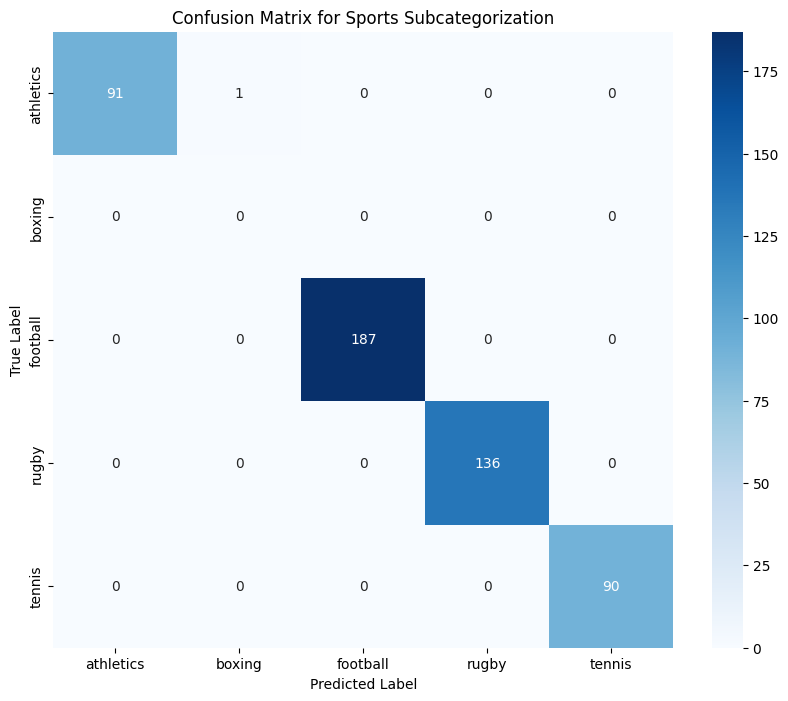

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define true and predicted labels
y_true = merged_df['category_ref']
y_pred = merged_df['subcategory']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Create a DataFrame for the metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-score (Weighted)'],
    'Score': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics_data)

print(" Classification Metrics:")
print(metrics_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get all unique labels from both true and predicted values
all_labels = sorted(list(set(y_true).union(set(y_pred))))
cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)

print("\n Confusion Matrix:")
plt.figure(figsize=(10, 8)) # Increased figure size for better readability
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sports Subcategorization')
plt.show()


In [ ]:
# Assuming y_true and y_pred already exist

from sklearn.metrics import confusion_matrix
import pandas as pd

# Get all unique labels from both true and predicted values
all_labels = sorted(list(set(y_true).union(set(y_pred))))

# Calculate the confusion matrix with all labels represented
cm = confusion_matrix(y_true, y_pred, labels=all_labels)
cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)

# Display or plot as needed
print(cm_df)


           athletics  boxing  football  rugby  tennis
athletics         91       1         0      0       0
boxing             0       0         0      0       0
football           0       0       187      0       0
rugby              0       0         0    136       0
tennis             0       0         0      0      90


Inspect Unique Labels

In [ ]:
# Show unique true labels (ground truth)
print(" Unique True Labels (category_ref):")
print(merged_df['category_ref'].unique())

# Show unique predicted labels (GPT subcategory predictions)
print("\n Unique Predicted Labels (subcategory):")
print(merged_df['subcategory'].unique())


 Unique True Labels (category_ref):
['athletics' 'football' 'rugby' 'tennis']

 Unique Predicted Labels (subcategory):
['athletics' 'boxing' 'football' 'rugby' 'tennis']


Check Column Names and Unique Subcategories

In [ ]:
import pandas as pd

# Load your reference and GPT CSVs
ref_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/bbcsport/bbcsport_reference_with_text.csv')
gpt_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/Subcategories/sport/bbc_sport_subcategories.csv')

# Show column names
print("Reference CSV columns:", ref_df.columns.tolist())
print("GPT CSV columns:", gpt_df.columns.tolist())

# Show unique subcategories/labels
print("\nReference CSV unique subcategories (category column):")
print(sorted(ref_df['category'].unique()))

print("\nGPT CSV unique subcategories (subcategory column):")
print(sorted(gpt_df['subcategory'].unique()))

Reference CSV columns: ['filename', 'category', 'text']
GPT CSV columns: ['filename', 'category', 'text', 'subcategory']

Reference CSV unique subcategories (category column):
['athletics', 'cricket', 'football', 'rugby', 'tennis']

GPT CSV unique subcategories (subcategory column):
['Athletics', 'Boxing', 'Football', 'Rugby', 'Tennis']


Error Analysis: Cricket vs Boxing Misclassifications

In [ ]:

# Step 1. Pull out cricket articles from reference data

cricket_articles = merged_df[merged_df['category_ref'] == 'cricket']

print(" All Cricket Articles (True Label = 'cricket'):")
print(cricket_articles[['filename_ref', 'category_ref', 'subcategory']])


# Step 2. Check how GPT classified these cricket articles

print("\n Cricket Articles with GPT Predicted Labels:")
for idx, row in cricket_articles.iterrows():
    print(f"Filename: {row['filename_ref']}, True: {row['category_ref']}, Predicted: {row['subcategory']}")


#  Step 3. Pull out all articles GPT classified as boxing

boxing_articles = merged_df[merged_df['subcategory'] == 'boxing']

print("\n All Articles Predicted as Boxing by GPT:")
print(boxing_articles[['filename_pred', 'category_ref', 'subcategory']])


# Step 4. Check if any true cricket articles were misclassified as boxing

cricket_as_boxing = boxing_articles[boxing_articles['category_ref'] == 'cricket']

print("\n Cricket Articles Misclassified as Boxing:")
print(cricket_as_boxing[['filename_pred', 'category_ref', 'subcategory']])


 All Cricket Articles (True Label = 'cricket'):
Empty DataFrame
Columns: [filename_ref, category_ref, subcategory]
Index: []

 Cricket Articles with GPT Predicted Labels:

 All Articles Predicted as Boxing by GPT:
   filename_pred category_ref subcategory
85       088.txt    athletics      boxing

 Cricket Articles Misclassified as Boxing:
Empty DataFrame
Columns: [filename_pred, category_ref, subcategory]
Index: []


In [ ]:
print(" Cricket articles in reference_df:")
print(reference_df[reference_df['category'] == 'cricket'][['filename', 'category']])


 Cricket articles in reference_df:
        filename category
101  cricket.001  cricket
102  cricket.002  cricket
103  cricket.003  cricket
104  cricket.004  cricket
105  cricket.005  cricket
..           ...      ...
220  cricket.120  cricket
221  cricket.121  cricket
222  cricket.122  cricket
223  cricket.123  cricket
224  cricket.124  cricket

[124 rows x 2 columns]


In [ ]:
print(" Cricket articles in subcat_df (GPT predictions):")
print(subcat_df[subcat_df['subcategory'].str.lower() == 'cricket'][['filename', 'subcategory']])


 Cricket articles in subcat_df (GPT predictions):
Empty DataFrame
Columns: [filename, subcategory]
Index: []


 Reload and Structure Original BBC Dataset

In [ ]:
import os
import pandas as pd

extract_dir = "/content/drive/MyDrive/NLP_Project/bbc/"
records = []

for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".txt"):
            category = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read()
                records.append({
                    "filename": file,
                    "category": category,
                    "text": text
                })

df_original = pd.DataFrame(records)
print(f" Reloaded original dataset: {len(df_original)} articles")


 Reloaded original dataset: 2225 articles


In [ ]:
df_raw = df_original.copy()

Validate Cricket Articles in Raw Dataset

In [ ]:
import pandas as pd

# Assuming:
# reference_df is your general reference dataframe
# df_raw is your unmodified original dataset with 2225 rows

# Extract cricket articles from reference_df
cricket_articles_ref = reference_df[reference_df['category'] == 'cricket'].copy()

# Standardize texts for consistent comparison
df_raw['text_cleaned'] = df_raw['text'].str.lower().str.strip()
cricket_articles_ref['text_cleaned'] = cricket_articles_ref['text'].str.lower().str.strip()

# Check which cricket articles are NOT present in df_raw
missing_cricket_in_raw = cricket_articles_ref[~cricket_articles_ref['text_cleaned'].isin(df_raw['text_cleaned'])]

print(f" Number of cricket articles NOT found in raw dataset: {len(missing_cricket_in_raw)}")
print(" Missing cricket article filenames (if any):")
print(missing_cricket_in_raw['filename'].tolist())

# Optional: Check how many cricket articles ARE found in df_raw
found_cricket_in_raw = cricket_articles_ref[cricket_articles_ref['text_cleaned'].isin(df_raw['text_cleaned'])]
print(f" Number of cricket articles found in raw dataset: {len(found_cricket_in_raw)}")


 Number of cricket articles NOT found in raw dataset: 124
 Missing cricket article filenames (if any):
['cricket.001', 'cricket.002', 'cricket.003', 'cricket.004', 'cricket.005', 'cricket.006', 'cricket.007', 'cricket.008', 'cricket.009', 'cricket.010', 'cricket.011', 'cricket.012', 'cricket.013', 'cricket.014', 'cricket.015', 'cricket.016', 'cricket.017', 'cricket.018', 'cricket.019', 'cricket.020', 'cricket.021', 'cricket.022', 'cricket.023', 'cricket.024', 'cricket.025', 'cricket.026', 'cricket.027', 'cricket.028', 'cricket.029', 'cricket.030', 'cricket.031', 'cricket.032', 'cricket.033', 'cricket.034', 'cricket.035', 'cricket.036', 'cricket.037', 'cricket.038', 'cricket.039', 'cricket.040', 'cricket.041', 'cricket.042', 'cricket.043', 'cricket.044', 'cricket.045', 'cricket.046', 'cricket.047', 'cricket.048', 'cricket.049', 'cricket.050', 'cricket.051', 'cricket.052', 'cricket.053', 'cricket.054', 'cricket.055', 'cricket.056', 'cricket.057', 'cricket.058', 'cricket.059', 'cricket.06

### Why GPT Predicted "Boxing" Instead of "Athletics"

This article is about **Marion Jones**, a famous **Olympic sprinter** (track & field), not a boxer. However, GPT likely got confused and labeled it as “boxing” because the article includes keywords often seen in boxing-related stories.

#### **Words/phrases often found in boxing or combat sports articles:**
- “Jones files lawsuit against Conte”
- “performance-enhancing drugs”
- “Balco boss Victor Conte”
- “charged… of distributing illegal steroids”
- “money laundering”
- “trial in March”
- “federal indictment”
- “anti-doping war”



In [ ]:
import pandas as pd
from IPython.display import display

# Load the GPT BBC sports subcategories CSV
gpt_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/Subcategories/sport/bbc_sport_subcategories.csv')

# Filter rows where subcategory is 'boxing' (case-insensitive)
boxing_df = gpt_df[gpt_df['subcategory'].str.lower() == 'boxing']

# Display the DataFrame nicely formatted
display(boxing_df)

print(boxing_df.to_string(index=False))


,filename,category,text,subcategory
36,088.txt,sport,Jones files lawsuit against Conte\n\nMarion Jo...,Boxing


filename category                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

#**Step 8: Heuristic Validation and Cleaning of NER Output**:

In [ ]:
!pip install nameparser

In [ ]:
import re
import pandas as pd
from nameparser import HumanName  # Add this import

# Path to your saved NER_named_entities CSV
ner_output = "/content/drive/MyDrive/NLP_Project/NER_named_entities.csv"

# Load the data directly
ner_df = pd.read_csv(ner_output)

# Define function to check if a value looks like a proper person name
def is_probably_person(name):
    name_str = str(name).strip()
    # Improved regex pattern
    regex_valid = bool(re.match(r'^(Mr\.|Mrs\.|Ms\.|Dr\.|Prof\.|Sir|Dame)?\s*([A-Z][a-zA-Z\'`\-]+(\s[A-Z][a-zA-Z\'`\-]+)*(\s[A-Z]\.)*)$', name_str))
    # nameparser check
    parsed = HumanName(name_str)
    nameparser_valid = bool(parsed.first and parsed.last)
    # Valid if either method returns True
    return regex_valid or nameparser_valid

# Apply combined name-checking function to the 'people' column
ner_df['valid_person'] = ner_df['people'].apply(is_probably_person)

# Split into valid and invalid name groups
valid_persons_df = ner_df[ner_df['valid_person'] == True]
invalid_persons_df = ner_df[ner_df['valid_person'] == False]

# Optional: Show counts
print(" Total rows:", len(ner_df))
print(" Valid person names:", len(valid_persons_df))
print(" Invalid/suspicious person names:", len(invalid_persons_df))

 Total rows: 5439
 Valid person names: 5405
 Invalid/suspicious person names: 34


calculate and display the heuristic precision as a percentage

In [ ]:
# Calculate precision
total_rows = len(ner_df)
valid_rows = len(valid_persons_df)
heuristic_precision = (valid_rows / total_rows) * 100

# Print result nicely formatted
print(f"Heuristic Precision: {heuristic_precision}%")


Heuristic Precision: 99.3748850891708%


In [ ]:
# Print result nicely formatted
rounded_precision = round(99.3748850891708)
print(f"Heuristic Precision: {rounded_precision}%")

Heuristic Precision: 99%


Displaying Valid and Invalid Named Entities

In [ ]:
# Display invalid_persons_df
from IPython.display import display

display(invalid_persons_df)

,filename,category,people,job_title,media_personality,valid_person
53,275.txt,business,SPD (Social Democrats),Ruling party in Germany,Other,False
84,248.txt,business,Bank of England,rate-setting committee members,Other,False
101,338.txt,business,Chief financial officer of Yili,Chief financial officer,Other,False
105,476.txt,business,NaN,NaN,Other,False
149,313.txt,business,NaN,NaN,Other,False
271,373.txt,business,K2,Sporting goods company,Other,False
273,415.txt,business,Bank of England,Financial institution,Other,False
522,233.txt,business,NaN,NaN,Other,False
561,026.txt,business,General Motors (GM),carmaker,Other,False
594,492.txt,business,Bank of America,Bank,Other,False


In [ ]:
# Display invalid_persons_df
from IPython.display import display

display(valid_persons_df)

,filename,category,people,job_title,valid_person
0,289.txt,business,David Frost,BCC director general,True
1,504.txt,business,Tony Blair,UK Prime Minister,True
2,504.txt,business,Jacques Chirac,French President,True
3,504.txt,business,Thabo Mbeki,South African President,True
4,504.txt,business,Viktor Yushchenko,Ukraine's new president,True
...,...,...,...,...,...
5434,092.txt,tech,John Doe,Defendant,True
5435,086.txt,tech,Andrew Pearson,European boss of Workshare,True
5436,290.txt,tech,F-Secure,Finnish security firm,True
5437,290.txt,tech,Sophos,Anti-virus firm,True


Media Personality Classification Based on Job Titles

In [ ]:
import re

# Keyword lists for classification
politician_keywords = ['prime minister', 'president', 'politician', 'minister', 'senator', 'mp', 'chancellor']
musician_keywords = ['singer', 'musician', 'rapper', 'artist', 'composer', 'dj']
tv_film_keywords = ['actor', 'actress', 'film', 'tv', 'director', 'producer', 'anchor', 'star', 'screenwriter', 'presenter']
media_keywords = [
    'journalist', 'reporter', 'editor', 'broadcaster', 'correspondent',
    'host', 'columnist', 'newsreader', 'commentator', 'spokesman', 'spokeswoman',
    'news anchor', 'radio', 'television', 'talk show host', 'film', 'tv', 'television',
    'media', 'entertainment', 'star', 'actor', 'actress', 'buffy', 'oscars', 'sundance',
    'slayer', 'director', 'producer', 'presenter', 'screenwriter', 'music', 'musical', 'theatre'
]
non_media_context = [
    'board', 'company', 'executive', 'business', 'finance', 'ceo', 'chairman',
    'directorat', 'outside director', 'corporate', 'telecom', 'WorldCom', 'at&t',
    'vodafone', 'investment', 'firm', 'bank', 'group', 'company', 'business', 'finance',
    'oil', 'telecoms', 'institute', 'corporation', 'association', 'development', 'government',
    'worldcom', 'industry', 'committee', 'department', 'technology', 'digital',
    'marketing', 'public', 'protection', 'university', 'school', 'infrastructure'

]

def classify_media_personality(job_title):
    job_title = str(job_title).lower()
    words = re.findall(r'\b\w+\b', job_title)

    # First filter out business/corporate roles
    if any(term in job_title for term in non_media_context):
        return 'Other'

    # Catch CamelCase hallucinated jobs like 'FormalOutsideDirectorAtWorldCom'
    if re.match(r'[A-Z][a-z]+(?:[A-Z][a-z]+)+', str(job_title)):
        return 'Other'

    # Apply classification based on keyword groups
    if any(word in words for word in politician_keywords):
        return 'Politician'
    elif any(word in words for word in musician_keywords):
        return 'Musician'
    elif any(word in words for word in tv_film_keywords):
        return 'TV/Film Personality'
    elif any(word in words for word in media_keywords):
        return 'Media Personality'
    else:
        return 'Other'

# Apply the classification
ner_df['media_personality'] = ner_df['job_title'].apply(classify_media_personality)

# Print out summary
for label in ['Politician', 'Musician', 'TV/Film Personality', 'Media Personality', 'Other']:
    count = (ner_df['media_personality'] == label).sum()
    print(f"Total {label}s found: {count}")

# View some samples of correct classifications
ner_df[ner_df['media_personality'] == 'Media Personality'][['people', 'job_title']].head(10)


Total Politicians found: 472
Total Musicians found: 300
Total TV/Film Personalitys found: 654
Total Media Personalitys found: 180
Total Others found: 3833


,people,job_title
9,Floiran Woest,Swiss Re's spokesman
49,Rob McIvor,FSA spokesman
56,Jonathan Beale,BBC reporter
67,Ian Perry,RICS housing spokesman
68,Alexander Shadrin,Yukos spokesman
72,Sarah Rainsford,BBC correspondent
169,Michael Lamberty,Lufthansa spokesman
198,Alexander Radwan,European People's Party spokesman
231,Jemma Smith,Apacs spokeswoman
407,Monica Chadha,BBC Delhi reporter


Visualization: Distribution of Media Personality Types


/tmp/ipython-input-116-308917517.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ner_df, x='media_personality', order=ner_df['media_personality'].value_counts().index, palette='viridis')


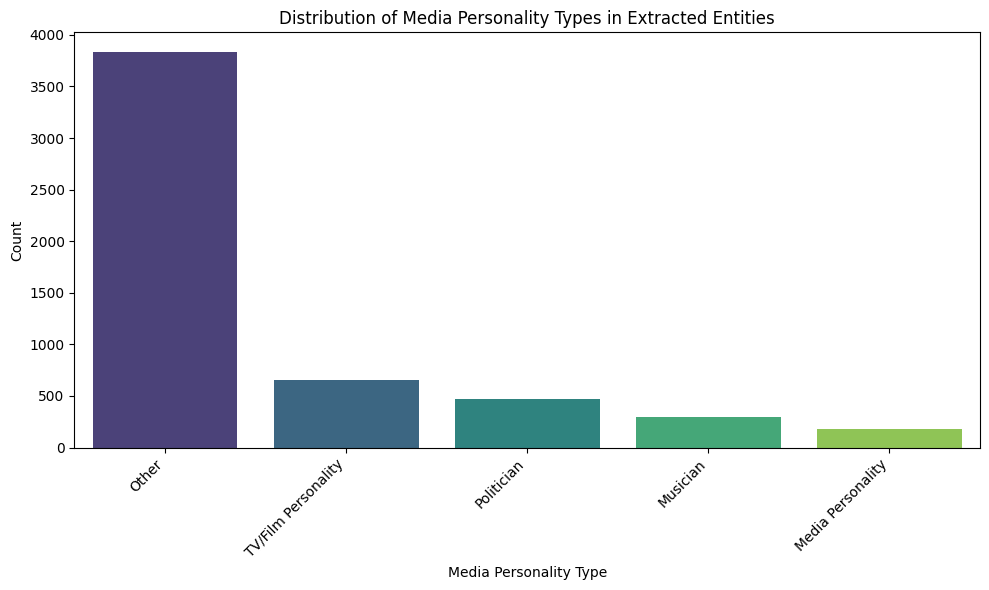

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn

# Visualize the distribution of media personality types
plt.figure(figsize=(10, 6))
sns.countplot(data=ner_df, x='media_personality', order=ner_df['media_personality'].value_counts().index, palette='viridis')
plt.title('Distribution of Media Personality Types in Extracted Entities')
plt.xlabel('Media Personality Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Review of Entries Classified as "Other"


In [ ]:
# Filter ner_df to show only rows where 'media_personality' is 'Other'
other_personalities_df = ner_df[ner_df['media_personality'] == 'Other']

# Display the resulting DataFrame
display(other_personalities_df)

print(f"\nTotal entries classified as 'Other': {len(other_personalities_df)}")

,filename,category,people,job_title,media_personality
5,504.txt,business,Mahmoud Abbas,Newly elected Palestinian leader,Other
6,504.txt,business,Bono,U2 frontman and campaigner on trade and develo...,Other
7,504.txt,business,Angelina Jolie,Goodwill campaigner for the UN on refugees,Other
8,262.txt,business,Hans Goetti,Fund manager,Other
10,276.txt,business,Suhas Naik,Investment Analyst,Other
...,...,...,...,...,...
5434,092.txt,tech,John Doe,Defendant,Other
5435,086.txt,tech,Andrew Pearson,European boss of Workshare,Other
5436,290.txt,tech,F-Secure,Finnish security firm,Other
5437,290.txt,tech,Sophos,Anti-virus firm,Other



Total entries classified as 'Other': 3833


Breakdown and visualization of Media Personality Type

In [ ]:
from IPython.display import display

# List of personality types to display (excluding 'Other', as that's handled separately)
personality_types_to_show = [
    'TV/Film Personality',
    'Politician',
    'Musician',
    'Media Personality'
]

# Loop through each personality type and display the corresponding DataFrame
for personality_type in personality_types_to_show:
    print(f"--- Entries classified as '{personality_type}' ---")

    # Filter ner_df to show only rows where 'media_personality' matches the current type
    filtered_df = ner_df[ner_df['media_personality'] == personality_type]

    # Display the resulting DataFrame (show head for potentially large data)
    display(filtered_df)

    print(f"\nTotal entries classified as '{personality_type}': {len(filtered_df)}\n")


--- Entries classified as 'TV/Film Personality' ---


,filename,category,people,job_title,media_personality
0,289.txt,business,David Frost,BCC director general,TV/Film Personality
106,310.txt,business,Tiger Woods,Sports Star,TV/Film Personality
348,036.txt,business,Sir Digby Jones,CBI director-general,TV/Film Personality
359,432.txt,business,Robert Boyle,BA director of commercial planning,TV/Film Personality
369,382.txt,business,Gordon Lishman,Director General of Age Concern England,TV/Film Personality
...,...,...,...,...,...
5406,246.txt,tech,Kelly Holmes,Olympic star,TV/Film Personality
5417,124.txt,tech,Nigel Whalley,Managing director of media consultancy Decipher,TV/Film Personality
5419,332.txt,tech,Mike McGuire,Research Director at Gartner,TV/Film Personality
5421,327.txt,tech,Lee Rainie,Director of the Pew Internet and American Life...,TV/Film Personality



Total entries classified as 'TV/Film Personality': 654

--- Entries classified as 'Politician' ---


,filename,category,people,job_title,media_personality
1,504.txt,business,Tony Blair,UK Prime Minister,Politician
2,504.txt,business,Jacques Chirac,French President,Politician
3,504.txt,business,Thabo Mbeki,South African President,Politician
4,504.txt,business,Viktor Yushchenko,Ukraine's new president,Politician
13,060.txt,business,Joshua Bewlay,Former Marsh senior vice president,Politician
...,...,...,...,...,...
5382,084.txt,tech,Satoru Iwata,Nintendo president,Politician
5388,318.txt,tech,Jim Lanzone,Vice President of Search Properties at Ask Jeeves,Politician
5408,246.txt,tech,Japanese prime minister,Prime Minister,Politician
5410,078.txt,tech,John Kerry,Politician,Politician



Total entries classified as 'Politician': 472

--- Entries classified as 'Musician' ---


,filename,category,people,job_title,media_personality
252,213.txt,business,Mozart,Composer,Musician
457,226.txt,business,Joss Stone,British singer,Musician
458,226.txt,business,Franz Ferdinand,Musician,Musician
820,276.txt,entertainment,Pete Doherty,Rock singer,Musician
829,048.txt,entertainment,Janet Jackson,Musician,Musician
...,...,...,...,...,...
5312,295.txt,tech,Gwen Stefani,Singer,Musician
5378,090.txt,tech,Mustafa Yoda,Argentine hip-hop artist,Musician
5380,090.txt,tech,Papo Record,Cuban hip-hop artist,Musician
5381,090.txt,tech,Tote King,Spanish hip-hop artist,Musician



Total entries classified as 'Musician': 300

--- Entries classified as 'Media Personality' ---


,filename,category,people,job_title,media_personality
9,262.txt,business,Floiran Woest,Swiss Re's spokesman,Media Personality
49,263.txt,business,Rob McIvor,FSA spokesman,Media Personality
56,249.txt,business,Jonathan Beale,BBC reporter,Media Personality
67,329.txt,business,Ian Perry,RICS housing spokesman,Media Personality
68,314.txt,business,Alexander Shadrin,Yukos spokesman,Media Personality
...,...,...,...,...,...
5326,056.txt,tech,ESPN,sports broadcaster,Media Personality
5343,123.txt,tech,Scott Stanzel,Spokesman for the Bush-Cheney campaign,Media Personality
5384,127.txt,tech,Oliver Irish,Editor of gadget magazine Stuff,Media Personality
5414,044.txt,tech,Dan Gillmor,Journalist,Media Personality



Total entries classified as 'Media Personality': 180



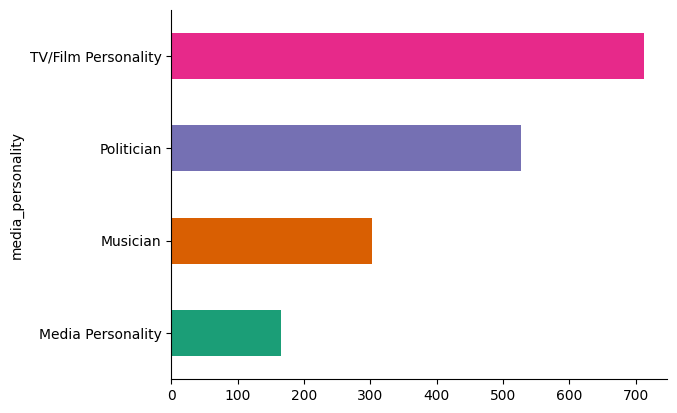

In [ ]:
# @title media_personality

from matplotlib import pyplot as plt
import seaborn as sns
filtered_df.groupby('media_personality').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

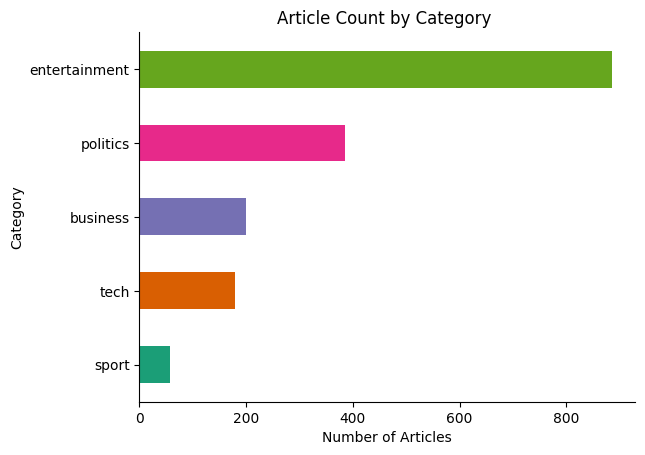

In [ ]:
# @title category

from matplotlib import pyplot as plt
import seaborn as sns

# Group by category and sort by count (descending)
category_counts = filtered_df['category'].value_counts(ascending=True)

# Plot horizontal bar chart, bars ordered from highest to lowest
category_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Articles")
plt.ylabel("Category")
plt.title("Article Count by Category ")
plt.show()

Save Filtered Media Personalities to CSV

In [ ]:
import pandas as pd

# Load your NER output
ner_output = "/content/drive/MyDrive/NLP_Project/NER_named_entities.csv"
ner_df = pd.read_csv(ner_output)

# Filter only desired personality types for saving
filtered_df = ner_df[ner_df['media_personality'].isin(['TV/Film Personality', 'Politician', 'Musician', 'Media Personality'])]

# Save the filtered DataFrame to CSV (without "Other")
save_path = "/content/drive/MyDrive/NLP_Project/NER_media_personalities.csv"
filtered_df.to_csv(save_path, index=False)
print(f"Filtered media personalities saved to: {save_path}")

# Optionally preview the saved CSV
loaded_csv_df = pd.read_csv(save_path)
print("\nPreview of the saved CSV:")
display(loaded_csv_df.head())

Filtered media personalities saved to: /content/drive/MyDrive/NLP_Project/NER_media_personalities.csv

Preview of the saved CSV:


,filename,category,people,job_title,media_personality
0,289.txt,business,David Frost,BCC director general,TV/Film Personality
1,504.txt,business,Tony Blair,UK Prime Minister,Politician
2,504.txt,business,Jacques Chirac,French President,Politician
3,504.txt,business,Thabo Mbeki,South African President,Politician
4,504.txt,business,Viktor Yushchenko,Ukraine's new president,Politician


Verify Media Personality Classification Output

In [ ]:
import pandas as pd

# Path to your NER output and media CSV
ner_output = "/content/drive/MyDrive/NLP_Project/NER_named_entities.csv"
media_csv = "/content/drive/MyDrive/NLP_Project/NER_media_personalities.csv"

# Load the original NER DataFrame
ner_df = pd.read_csv(ner_output)
print(f"Total rows in original ner_df: {len(ner_df)}")

# Count rows where media_personality is "Other"
total_other = (ner_df['media_personality'] == 'Other').sum()
print(f"Total 'Other' rows in NER_named_entities.csv: {total_other}")

# Load the filtered media personalities CSV
media_df = pd.read_csv(media_csv)
print(f"Total rows in NER_media_personalities.csv (after dropping 'Other'): {len(media_df)}")

Total rows in original ner_df: 5439
Total 'Other' rows in NER_named_entities.csv: 3732
Total rows in NER_media_personalities.csv (after dropping 'Other'): 1707


In [ ]:
total_predictions = 5439
valid_predictions = 1707  # Entities classified as Politician, Musician, TV/Film Personality, Media Personality

precision = accuracy = (valid_predictions / total_predictions) * 100

print(f"Precision = Accuracy = Number of valid/correct predictions / Total predictions")
print(f"Precision = Accuracy = {valid_predictions} / {total_predictions} = {precision:.2f}%")

Precision = Accuracy = Number of valid/correct predictions / Total predictions
Precision = Accuracy = 1707 / 5439 = 31.38%


#**Step 9: Validation and Cleaning of April_events Output**:

In [ ]:
import pandas as pd
import re
from IPython.display import display

# Path to your April events summary CSV
april_output_path = "/content/drive/MyDrive/NLP_Project/April_events_summary.csv"

# Load the data
april_df = pd.read_csv(april_output_path)

# Define negative patterns (expand as needed)
negative_patterns = [
    "no specific events mentioned",
    "no events mentioned",
    "no events",
    "not applicable",
    "not mentioned",
    "there are no events mentioned",
    "no event mentioned",
    "no april events",
    "no events in the article for april",
    "no events in the article specifically for april"
]

def is_valid_april_event(entry):
    entry_str = str(entry).strip().lower()
    if any(pattern in entry_str for pattern in negative_patterns):
        return False
    return True

# Apply the validation function
april_df['is_valid_event'] = april_df['april_events'].apply(is_valid_april_event)

# Split into valid and invalid event groups
valid_events_df = april_df[april_df['is_valid_event'] == True]
invalid_events_df = april_df[april_df['is_valid_event'] == False]

# Print comparative analysis
print("April Events Comparative Analysis")
print(f"Total predictions: {len(april_df)}")
print(f"Valid predictions (True): {len(valid_events_df)}")
print(f"Wrong predictions (False): {len(invalid_events_df)}\n")

print("All VALID April event predictions:")
display(valid_events_df[['filename', 'category', 'april_events']])

April Events Comparative Analysis
Total predictions: 862
Valid predictions (True): 212
Wrong predictions (False): 650

All VALID April event predictions:


,filename,category,april_events
18,301.txt,business,"- The US lifted a trade ban on Libya in April,..."
19,315.txt,business,- Scottish and Newcastle (S&N) extends its Ind...
20,473.txt,business,- The merger of Nigerian banks United Bank of ...
22,314.txt,business,- Baikal Finance Group outbid Gazprom to buy t...
35,310.txt,business,- Nike reported worldwide futures orders for a...
...,...,...,...
816,108.txt,tech,- Microsoft aims to launch search software to ...
848,252.txt,tech,- The original Zafi virus appeared in April th...
849,078.txt,tech,"- The rise of blog readership, with 32 million..."
859,045.txt,tech,- The spring launch of the PSP in the UK is ea...


In [ ]:
print("\nAll WRONG April event predictions:")
display(invalid_events_df[['filename', 'category', 'april_events']])


All WRONG April event predictions:


,filename,category,april_events
0,060.txt,business,- No specific events mentioned in the article ...
1,100.txt,business,- No specific events mentioned in the article ...
2,128.txt,business,- No specific events mentioned in the article ...
3,464.txt,business,- No specific events mentioned in the article ...
4,115.txt,business,- No specific events mentioned in the article ...
...,...,...,...
855,333.txt,tech,- No specific events mentioned in the article ...
856,131.txt,tech,- No specific events mentioned in the article ...
857,119.txt,tech,- No specific events mentioned in the article ...
858,051.txt,tech,No specific events mentioned in the article fo...


In [ ]:
no_event_df = april_df[april_df['is_valid_event'] == False]

print(f"Articles with April events found: {len(valid_events_df)}")
print(f"Articles with no April event mentioned: {len(no_event_df)}")

Articles with April events found: 212
Articles with no April event mentioned: 650


In [ ]:
# Drop all WRONG predictions (where is_valid_event == False)
april_df_cleaned = april_df[april_df['is_valid_event'] == True]

# Save the cleaned DataFrame back to the same file (overwriting)
april_df_cleaned.to_csv(april_output_path, index=False)

print("All WRONG April event predictions have been dropped and file updated.")

All WRONG April event predictions have been dropped and file updated.


In [ ]:
# remove "-" character from April _events_summary.csv file

import pandas as pd
# Define the file path
april_path = "/content/drive/MyDrive/NLP_Project/April_events_summary.csv"

# Load the data
df = pd.read_csv(april_path)

# Remove the "-" character from the 'april_events' column
df['april_events'] = df['april_events'].astype(str).str.replace('-', '', regex=False)

# Save the modified DataFrame back to the same file
df.to_csv(april_path, index=False)

print("Successfully removed '-' character from 'april_events' in", april_path)


Successfully removed '-' character from 'april_events' in /content/drive/MyDrive/NLP_Project/April_events_summary.csv


Number of Articles with Valid April Events per Category:


,Category,Number of April Events
0,sport,58
1,entertainment,52
2,politics,43
3,business,39
4,tech,20


/tmp/ipython-input-143-4067773586.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Number of April Events', data=april_events_by_category, palette='viridis')


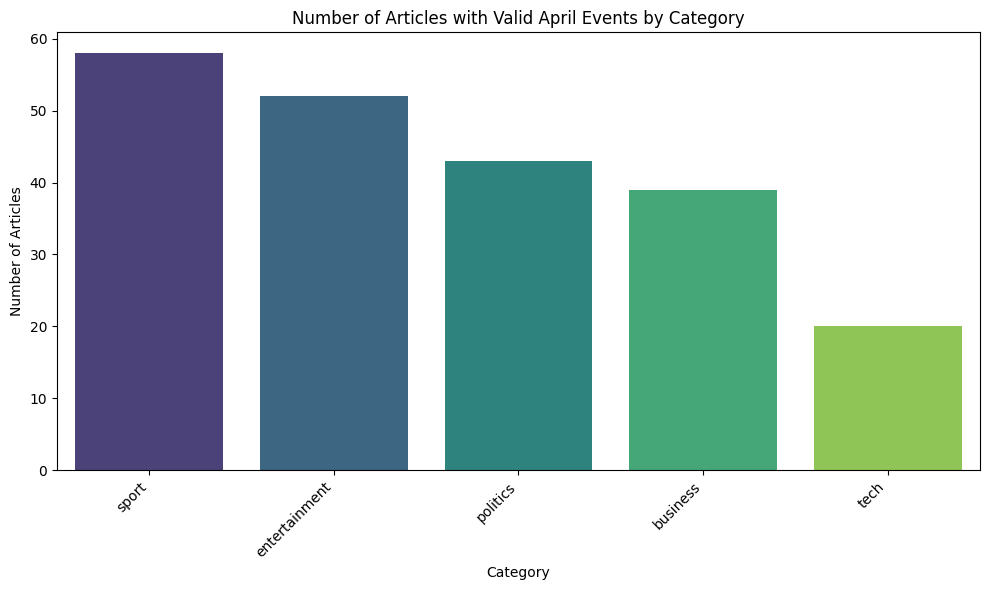

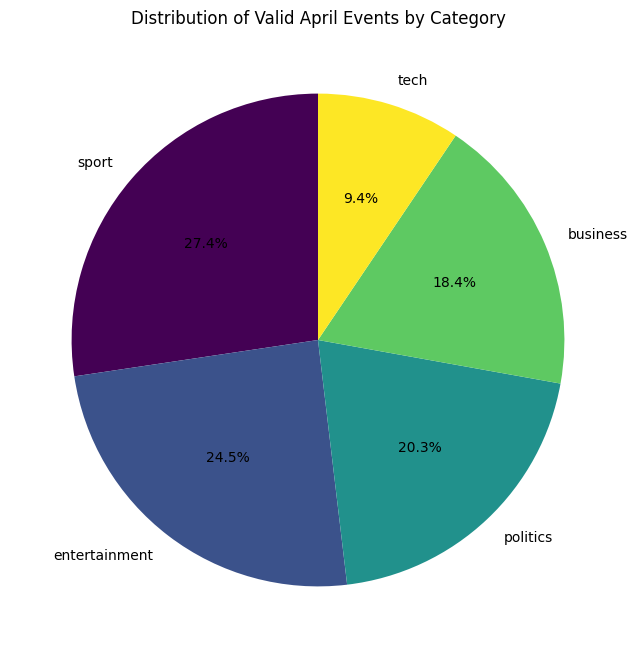

In [ ]:
# visualize result

import pandas as pd
import matplotlib.pyplot as plt


# Count the number of valid April events per category
april_events_by_category = april_df_cleaned['category'].value_counts().reset_index()
april_events_by_category.columns = ['Category', 'Number of April Events']

print("Number of Articles with Valid April Events per Category:")
display(april_events_by_category)

# Visualize the number of April events per category
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Number of April Events', data=april_events_by_category, palette='viridis')
plt.title('Number of Articles with Valid April Events by Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize the distribution of valid April events
plt.figure(figsize=(8, 8))
april_df_cleaned['category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribution of Valid April Events by Category')
plt.ylabel('') # Remove the default 'category' label on the y-axis
plt.show()


#**Step 10: Streamlit Graphic User Interface (GUI)**

In [ ]:

%%writefile streamlit_app.py


import streamlit as st
import pandas as pd
import altair as alt

# Button to clear cache manually
if st.sidebar.button("🔄 Reload Data"):
    st.cache_data.clear()

@st.cache_data
def load_data():
    articles = pd.read_csv("bbc_full_combined.csv")
    subcats = pd.read_csv("bbc_combined_subcategories.csv")
    ner = pd.read_csv("NER_media_personalities.csv")
    april = pd.read_csv("April_events_summary.csv")
    return articles, subcats, ner, april

# Load data
articles, subcats, ner, april = load_data()

# --- Use dataframes separately, no merging ---
# Clean up filename columns for consistency
articles['filename'] = articles['filename'].astype(str).str.strip()
subcats['filename'] = subcats['filename'].astype(str).str.strip()
april['filename'] = april['filename'].astype(str).str.strip()

# --- Sidebar: Filters, Downloads, Feedback ---
st.sidebar.header("Filters")
selected_category = st.sidebar.selectbox("Category", articles['category'].dropna().unique().tolist())
search_term = st.sidebar.text_input("Search by filename")

filtered_articles = articles.copy()
if selected_category:
    filtered_articles = filtered_articles[filtered_articles['category'] == selected_category]
if search_term:
    term = search_term.lower()
    filtered_articles = filtered_articles[
        filtered_articles['text'].astype(str).str.lower().str.contains(term, na=False)
        | filtered_articles['filename'].astype(str).str.lower().str.contains(term, na=False)
        | filtered_articles['category'].astype(str).str.lower().str.contains(term, na=False)
    ]

st.sidebar.header("Download Results")
st.sidebar.download_button("Download Filtered Articles CSV", filtered_articles.to_csv(index=False), "filtered_articles.csv")
st.sidebar.download_button("Download NER Results CSV", ner.to_csv(index=False), "ner_results.csv")
st.sidebar.download_button("Download April Events CSV", april.to_csv(index=False), "april_events.csv")
st.sidebar.download_button("Download Subcategories CSV", subcats.to_csv(index=False), "subcategories.csv")
st.sidebar.download_button("Download Full Articles CSV", articles.to_csv(index=False), "full_articles.csv")


# --- Main Page Content (No Tabs) ---

st.title("BBC NEWS ARTICLE EXPLORER")
st.markdown("""


- Browse and filter BBC news articles by category and subcategory
- Explore named entity recognition (NER) results for media personalities
- Use the sidebar to filter articles and download results
- Search articles by filename or text content
- Download filtered results and full datasets
- View summaries of April events
""")

st.subheader("Category Overview")
cat_counts = articles['category'].value_counts().reset_index()
cat_counts.columns = ['Category', 'Count']
st.altair_chart(
    alt.Chart(cat_counts).mark_bar().encode(
        x='Count:Q',
        y=alt.Y('Category:N', sort='-x'),
        color=alt.value("#FFB07C")  # Peach color
    ),
    use_container_width=True
)

st.subheader("Filtered Articles")
st.dataframe(filtered_articles, use_container_width=True)

st.subheader("Subcategory Explorer")
subcat_list = ['All'] + subcats['subcategory'].dropna().unique().tolist()
selected_subcat_explorer = st.selectbox("Filter by Subcategory", subcat_list)
if selected_subcat_explorer == 'All':
    subcats_filtered = subcats
else:
    subcats_filtered = subcats[subcats['subcategory'] == selected_subcat_explorer]
st.dataframe(subcats_filtered, use_container_width=True)


# Add a bar chart for category counts in the filtered subcategories
if not subcats_filtered.empty:
    subcat_counts = subcats_filtered['category'].value_counts().reset_index()
    subcat_counts.columns = ['Category', 'Count']
    st.altair_chart(
        alt.Chart(subcat_counts).mark_bar().encode(
            x='Count:Q',
            y=alt.Y('Category:N', sort='-x'),
            color=alt.value("#08AB46")  # Peach color for consistency
        ),
        use_container_width=True
    )

# NER Explorer
st.subheader("NER Explorer")
selected_role = st.selectbox("Filter by Media Role", ['All'] + ner['media_personality'].dropna().unique().tolist())
if selected_role == 'All':
    ner_filtered = ner
else:
    ner_filtered = ner[ner['media_personality'] == selected_role]
st.dataframe(ner_filtered, use_container_width=True)

# Add a bar chart for media_personality counts
if not ner_filtered.empty:
    mp_counts = ner_filtered['media_personality'].value_counts().reset_index()
    mp_counts.columns = ['Media Personality', 'Count']
    st.altair_chart(
        alt.Chart(mp_counts).mark_bar().encode(
            x='Count:Q',
            y=alt.Y('Media Personality:N', sort='-x'),
            color=alt.value("#71DCEE")  # Peach color
        ),
        use_container_width=True
    )

# April Events Explorer
st.subheader("April Events Explorer")
april_cat_list = ['All'] + april['category'].dropna().unique().tolist()
selected_april_cat = st.selectbox("Filter by April Event Category", april_cat_list, key="april_event_cat")
if selected_april_cat == 'All':
    april_filtered = april
else:
    april_filtered = april[april['category'] == selected_april_cat]
st.dataframe(april_filtered, use_container_width=True)


# Add a bar chart for April events in the filtered categories
if not april_filtered.empty:
    april_counts = april_filtered['category'].value_counts().reset_index()
    april_counts.columns = ['Category', 'Count']
    st.altair_chart(
        alt.Chart(april_counts).mark_bar().encode(
            x='Count:Q',
            y=alt.Y('Category:N', sort='-x'),
            color=alt.value("#e15759")
        ),
        use_container_width=True
    )


# Footer
st.caption("Built with Streamlit by Udodirim Nwosu")
st.markdown("This app is part of the BBC NLP project.")

Writing streamlit_app.py


In [ ]:
import os
import shutil

source_path = "/content/streamlit_app.py"
destination_path = "/content/drive/MyDrive/NLP_Project/streamlit_app.py"

try:
    shutil.move(source_path, destination_path)
    print(f"Successfully moved {source_path} to {destination_path}")
except FileNotFoundError:
    print(f"Error: {source_path} not found.")
except Exception as e:
    print(f"An error occurred while moving the file: {e}")

Successfully moved /content/streamlit_app.py to /content/drive/MyDrive/NLP_Project/streamlit_app.py
